In [1]:
import torch
import numpy as np
import cv2
import best.singular_point as sp
from teste_util import *
import teste_util as TS

# Fixar a semente do Torch para operações específicas
fixed_seed()

# leitura dos dados
trainloader,testloader =read_dataload_flower(sp.args.img_size,'./data/datasets')
iterator=iter(testloader)
img,labels = next(iterator)
print(img.shape,labels.shape)

# Carregar o modelo singular points
path_siamese = './data/models/sp_map_fo_30.pth'
sp.args.num_channels = 1
model = sp.SingularPoints(args=sp.args).to(sp.device)
load_model(model,path_siamese,sp.device)

#gerar variacao de transformacoes pespectivas e fotometrica
params_lists =AugmentationParamsGenerator(6,img.shape)


torch.Size([60, 1, 120, 120]) torch.Size([60])
Namespace(exported=False, num_channels=1, pyramid_levels=3, scale_pyramid=1.3, dim_first=3, dim_second=5, dim_third=8, group_size=36, epochs=70, border_size=12, box_size=21, nms_size=5, img_size=120, batch_size=16, path_data='./data', path_model='model.pt', is_loss_ssim=True, margin_loss=2.0, outlier_rejection=False, show_feature=False)


/home/wagner/.local/lib/python3.11/site-packages/e2cnn/nn/modules/r2_conv/basisexpansion_singleblock.py:80: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  full_mask[mask] = norms.to(torch.uint8)


Model loaded from ./data/models/sp_map_fo_30.pth


In [2]:
import argparse

## for fix seed
import random, torch, numpy 
def get_config(jupyter=False):
    parser = argparse.ArgumentParser(description='Train REKD Architecture')

    ## basic configuration
    parser.add_argument('--data_dir', type=str, default='../ImageNet2012/ILSVRC2012_img_val', #default='path-to-ImageNet',
                            help='The root path to the data from which the synthetic dataset will be created.')
    parser.add_argument('--synth_dir', type=str, default='', 
                            help='The path to save the generated sythetic image pairs.')
    parser.add_argument('--log_dir', type=str, default='trained_models/weights',
                            help='The path to save the REKD weights.')
    parser.add_argument('--load_dir', type=str, default='',
                        help='Set saved model parameters if resume training is desired.')                            
    parser.add_argument('--exp_name', type=str, default='REKD',
                            help='The Rotaton-equivaraiant Keypoint Detection (REKD) experiment name')
    ## network architecture
    parser.add_argument('--factor_scaling_pyramid', type=float, default=1.2,
                        help='The scale factor between the multi-scale pyramid levels in the architecture.')
    parser.add_argument('--group_size', type=int, default=36,  
                        help='The number of groups for the group convolution.')
    parser.add_argument('--dim_first', type=int, default=2,
                        help='The number of channels of the first layer')
    parser.add_argument('--dim_second', type=int, default=2,
                        help='The number of channels of the second layer')
    parser.add_argument('--dim_third', type=int, default=2,
                        help='The number of channels of the thrid layer')                       
    ## network training
    parser.add_argument('--batch_size', type=int, default=16,
                        help='The batch size for training.')
    parser.add_argument('--num_epochs', type=int, default=20, 
                        help='Number of epochs for training.')
    ## Loss function  
    parser.add_argument('--init_initial_learning_rate', type=float, default=1e-3,
                        help='The init initial learning rate value.')
    parser.add_argument('--MSIP_sizes', type=str, default="8,16,24,32,40",
                        help='MSIP sizes.')
    parser.add_argument('--MSIP_factor_loss', type=str, default="256.0,64.0,16.0,4.0,1.0",
                        help='MSIP loss balancing parameters.')
    parser.add_argument('--ori_loss_balance', type=float, default=100., 
                        help='')
    ## Dataset generation
    parser.add_argument('--patch_size', type=int, default=192,
                        help='The patch size of the generated dataset.')
    parser.add_argument('--max_angle', type=int, default=180,
                        help='The max angle value for generating a synthetic view to train REKD.')
    parser.add_argument('--min_scale', type=float, default=1.0,
                        help='The min scale value for generating a synthetic view to train REKD.')
    parser.add_argument('--max_scale', type=float, default=1.0,
                        help='The max scale value for generating a synthetic view to train REKD.')
    parser.add_argument('--max_shearing', type=float, default=0.0,
                        help='The max shearing value for generating a synthetic view to train REKD.')
    parser.add_argument('--num_training_data', type=int, default=9000,
                        help='The number of the generated dataset.')
    parser.add_argument('--is_debugging', type=bool, default=False,
                        help='Set variable to True if you desire to train network on a smaller dataset.')
    ## For eval/inference
    parser.add_argument('--num_points', type=int, default=1500,
                        help='the number of points at evaluation time.')
    parser.add_argument('--pyramid_levels', type=int, default=5,
                        help='downsampling pyramid levels.')
    parser.add_argument('--upsampled_levels', type=int, default=2,
                        help='upsampling image levels.')
    parser.add_argument('--nms_size', type=int, default=15,
                        help='The NMS size for computing the validation repeatability.')
    parser.add_argument('--border_size', type=int, default=15,
                        help='The number of pixels to remove from the borders to compute the repeatability.')
    ## For HPatches evaluation
    parser.add_argument('--hpatches_path', type=str, default='./datasets/hpatches-sequences-release',
                        help='dataset ')
    parser.add_argument('--eval_split', type=str, default='debug',
                        help='debug, view, illum, full, debug_view, debug_illum ...')      
    parser.add_argument('--descriptor', type=str, default="hardnet",
                        help='hardnet, sosnet, hynet')    

    args = parser.parse_args() if not jupyter else parser.parse_args(args=[])   

    fixed_seed()

    if args.synth_dir == "":
        args.synth_dir = 'datasets/synth_data'

    args.MSIP_sizes = [int(i) for i in args.MSIP_sizes.split(",")]
    args.MSIP_factor_loss =[float(i) for i in args.MSIP_factor_loss.split(",")]

    return args




In [3]:
from external.REKD import REKD, count_model_parameters
from external.hardnet_pytorch import HardNet

args = get_config(jupyter=True)
args.load_dir =  'trained_models/release_group36_f2_s2_t2.log/best_model.pt'

device = torch.device('cuda')


from torch import nn
class Detector(nn.Module):
        def __init__(self) -> None:
           super().__init__()
           detec = REKD(args, device)
           detec = detec.to(device) ## use GPU
           detec.load_state_dict(torch.load(args.load_dir))  ## Load the PyTorch learnable model parameters.
           detec.eval()
           self.model = detec
           
        def forward(self, x):
            features_key,features_ori= self.model(x)
            return features_key
        
        
class Descriptor(nn.Module):
        def __init__(self) -> None:
           super().__init__()           
           hardnet = HardNet()
           checkpoint = torch.load('trained_models/pretrained_nets/HardNet++.pth')
           hardnet.load_state_dict(checkpoint['state_dict'])
           hardnet.eval()
           hardnet.to(device) 
           self.model = hardnet
        def forward(self, x):
           return self.model(x)

detec = Detector()
desc = Descriptor()
print("Model paramter : {} is loaded.".format( args.load_dir ))
count_model_parameters(detec)
count_model_parameters(desc)

Model paramter : trained_models/release_group36_f2_s2_t2.log/best_model.pt is loaded.
================ List of Learnable model parameters ================ 
model.block1.0.weights torch.Size([22])
model.block1.1.batch_norm_[36].weight torch.Size([2])
model.block1.1.batch_norm_[36].bias torch.Size([2])
model.block2.0.weights torch.Size([1584])
model.block2.1.batch_norm_[36].weight torch.Size([2])
model.block2.1.batch_norm_[36].bias torch.Size([2])
model.block3.0.weights torch.Size([1584])
model.block3.1.batch_norm_[36].weight torch.Size([2])
model.block3.1.batch_norm_[36].bias torch.Size([2])
model.ori_learner.0.weights torch.Size([72])
model.last_layer_learner.0.weight torch.Size([6])
model.last_layer_learner.0.bias torch.Size([6])
model.last_layer_learner.1.weight torch.Size([1, 6, 1, 1])
model.last_layer_learner.1.bias torch.Size([1])
The number of learnable parameters : 3293 
================ List of Learnable model parameters ================ 
model.features.0.weight torch.Size([32,

In [4]:
import torch
import kornia
from kornia.feature.scale_space_detector import get_default_detector_config, MultiResolutionDetector
from kornia.feature.keynet import KeyNetDetector
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
PS = 32 # patch size
keynet_default_config = {
    'num_filters': 8,
    'num_levels': 3,
    'kernel_size': 5,
    'Detector_conf': {'nms_size': 15, 'pyramid_levels': 1, 'up_levels': 1, 'scale_factor_levels': 1.3, 's_mult': 22.0},
}

# timg_gray = img.to(device)#timg_gray.to(device)
TS.PS=32
sift = kornia.feature.SIFTDescriptor(PS, rootsift=True).to(sp.device)
descriptor = desc#sift
detector = CustomNetDetector(detec,PS=TS.PS).to(sp.device)

In [5]:
def detect_and_extract_features(image, detector, descriptor, PS):
    with torch.no_grad():
        lafs, resps = detector(image[None])
        # print('lafs  ',lafs.shape)
        patches = kornia.feature.extract_patches_from_pyramid(image[None], lafs, PS)
        B, N, CH, H, W = patches.size()
        # print('patches  ',patches.shape)
        descs = descriptor(patches.view(B * N, CH, H, W)).view(B, N, -1)
        # print('descs  ',descs.shape)
        return lafs, descs
    
def detect_extract_feat_in_batch(batch_img, detector, descriptor, PS):
    repo_lafs_desc = []
    with torch.no_grad():
        for image  in batch_img:
            
            lafs, resps = detector(image[None])
            patches = kornia.feature.extract_patches_from_pyramid(image[None], lafs, PS)
            print(lafs.shape,patches.shape)
            B, N, CH, H, W = patches.size()
            descs = descriptor(patches.view(B * N, CH, H, W)).view(B, N, -1)
            repo_lafs_desc.append((lafs,descs))
    return repo_lafs_desc
    

def matching_imagens(ref_img,batch_img, repo_lafs_desc):
    best_match_info = None
    best_match_count = 0
    best_match_index = None
    with torch.no_grad():
        # Detectar e extrair características da imagem de referência
        lafs_ref, descs_ref = detect_and_extract_features(ref_img, detector, descriptor, PS)
        
        for i, (lafs_i, descs_i) in enumerate(repo_lafs_desc):
            # Detectar e extrair características da imagem atual do batch
            # lafs_i, descs_i = detect_and_extract_features(img, detector, descriptor, PS)
            # Comparar as características da imagem de referência com a imagem atual do batch
            scores, matches = kornia.feature.match_snn(descs_ref[0], descs_i[0], 0.85) # correspondencia dos descritories a uma distância de 0.9

            if matches.shape[0] >= 4:
                # Cálculo da homografia
                inliers_mask = compute_homography(lafs_ref, lafs_i, matches)
                # print(lafs_ref[0][None].shape, lafs_ref[0].shape, matches.shape, inliers_mask.shape)

                # Check if this match is better than the previous best match
                if matches.shape[0] > best_match_count:
                    best_match_info = (lafs_ref[0][None].cpu(), lafs_i[0][None].cpu(), matches.cpu(),
                                       kornia.tensor_to_image(ref_img.cpu()), kornia.tensor_to_image(batch_img[i].cpu()),
                                       inliers_mask)
                    best_match_count = matches.shape[0]
                    best_match_index = i

        if best_match_info is not None and best_match_index==0:# TODO: Remove this condition best_match_index==0
            # Plot the best match
            from kornia_moons.viz import draw_LAF_matches

            draw_LAF_matches(
                *best_match_info,
                draw_dict={"inlier_color": (0.2, 1, 0.2), "tentative_color": (1, 1, 0.2, 0.3), "feature_color": None, "vertical": False},
            )
        # else:
        #     print("No matches found with enough inliers.")
    return best_match_index


  0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([1, 60, 2, 3]) torch.Size([1, 60, 1, 32, 32])
torch.Size([1, 60, 2, 3]) torch.Size([1, 60, 1, 32, 32])
torch.Size([1, 60, 2, 3]) torch.Size([1, 60, 1, 32, 32])
torch.Size([1, 60, 2, 3]) torch.Size([1, 60, 1, 32, 32])
torch.Size([1, 60, 2, 3]) torch.Size([1, 60, 1, 32, 32])
torch.Size([1, 60, 2, 3]) torch.Size([1, 60, 1, 32, 32])
torch.Size([1, 60, 2, 3]) torch.Size([1, 60, 1, 32, 32])
torch.Size([1, 60, 2, 3]) torch.Size([1, 60, 1, 32, 32])
torch.Size([1, 60, 2, 3]) torch.Size([1, 60, 1, 32, 32])
torch.Size([1, 60, 2, 3]) torch.Size([1, 60, 1, 32, 32])
torch.Size([1, 60, 2, 3]) torch.Size([1, 60, 1, 32, 32])
torch.Size([1, 60, 2, 3]) torch.Size([1, 60, 1, 32, 32])
torch.Size([1, 60, 2, 3]) torch.Size([1, 60, 1, 32, 32])
torch.Size([1, 60, 2, 3]) torch.Size([1, 60, 1, 32, 32])
torch.Size([1, 60, 2, 3]) torch.Size([1, 60, 1, 32, 32])
torch.Size([1, 60, 2, 3]) torch.Size([1, 60, 1, 32, 32])
torch.Size([1, 60, 2, 3]) torch.Size([1, 60, 1, 32, 32])
torch.Size([1, 60, 2, 3]) torch

KeyboardInterrupt: 

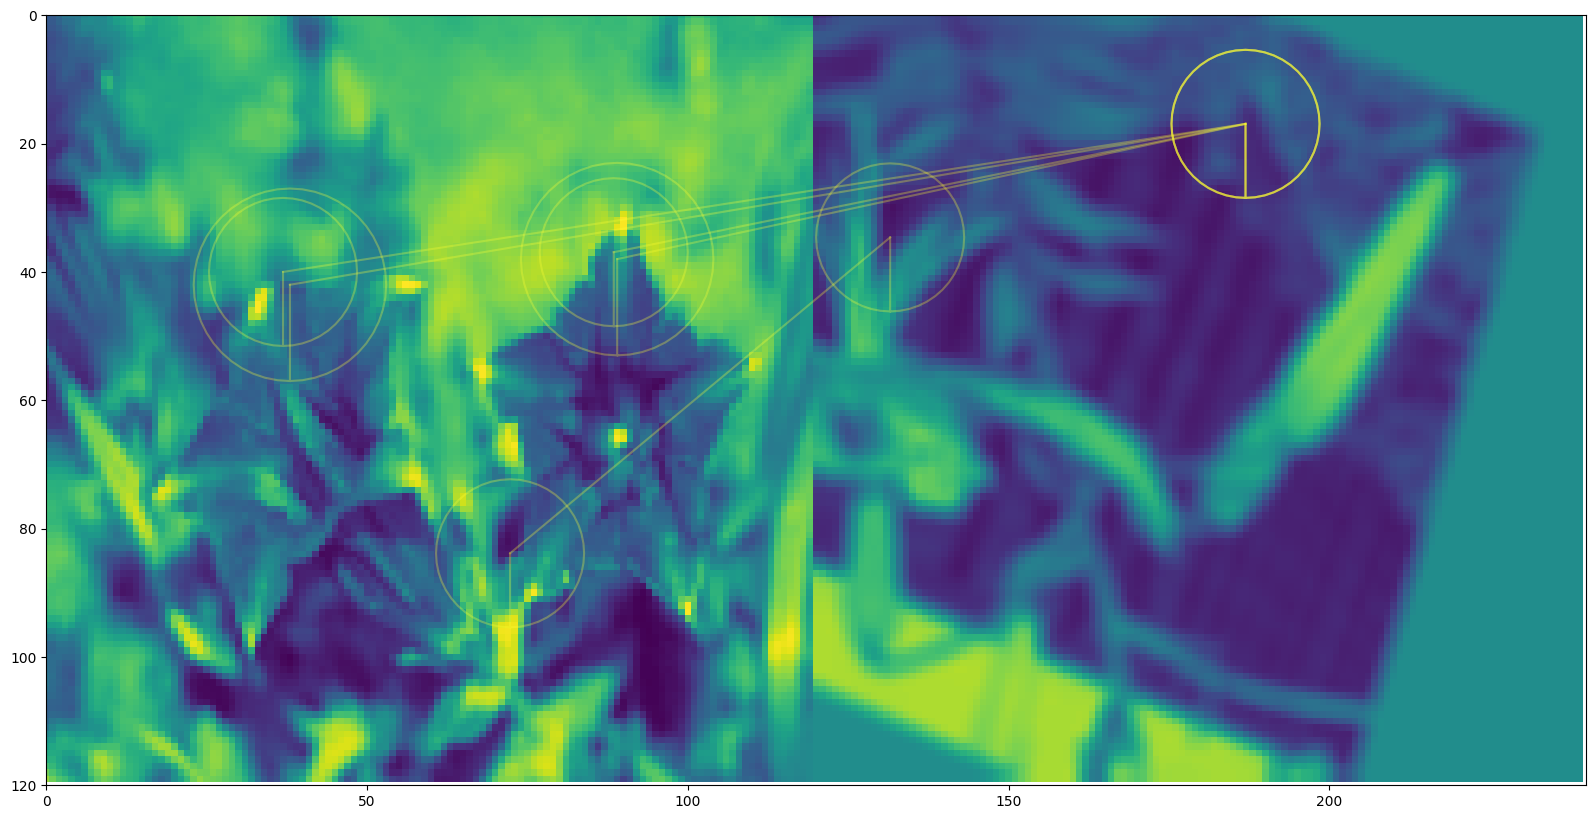

: 

In [6]:
params_lists.aug_list.data_keys =["input"]
aug_list = params_lists.aug_list

acertos = 0
total = 0
from tqdm.notebook import tqdm
pbar =  tqdm(testloader)
for imgs_batch,labels_batch in pbar:# itera em todo dataset
    imgs_batch = imgs_batch.to(sp.device)
    
    params_item = next(params_lists)
    timg_gray_t = aug_list(imgs_batch,params=params_item)
    repo_lafs_desc= detect_extract_feat_in_batch(timg_gray_t,detector,descriptor,TS.PS)
        
    for i,img_gray in enumerate(imgs_batch):# itera em cada batch

        match_index = matching_imagens(img_gray,timg_gray_t,repo_lafs_desc)
        # print("match_index: ",match_index," i: ",i)
        total+=1
        if match_index == i:
            acertos += 1
        pbar.set_description(f"acertos/total: {acertos}/{total}  ")
print("acertos: ",acertos)